Beta-discrete-Weibull (BdW) Model

**Source**:
- [“How to Project Customer Retention” Revisited: The Role of Duration Dependence](https://brucehardie.com/papers/037/)

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import beta, chi2
from scipy.special import beta as beta_fn
from scipy.special import hyp2f1

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import display_markdown

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [2]:
year, alive_regular, alive_highend = np.loadtxt('data/2-segment-retention.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
year = year.astype(int)

alive_regular = alive_regular.astype(float)
survivor_function_regular = alive_regular/alive_regular[0]
retention_rate_regular = survivor_function_regular[1:] / survivor_function_regular[:-1]

alive_highend = alive_highend.astype(float)
survivor_function_highend = alive_highend/alive_highend[0]
retention_rate_highend = survivor_function_highend[1:] / survivor_function_highend[:-1]

In [3]:
# Polarization Index = φ = 1/(γ+δ+1)
def polarization_index(gamma, delta):
    return 1/(gamma+delta+1) 

# Mean E(Θ) = γ/(γ+δ)
def beta_mean(gamma, delta):
    return gamma/(gamma+delta)

# https://www.wolframalpha.com/input?i2d=true&i=Divide%5Ba%2Ca%2Bb%5D%3Dj+and+Divide%5B1%2Ca%2Bb%2B1%5D%3Dp%5C%2844%29+solve+for+a+and+b
def beta_params(polarizaition, mean):
    gamma = mean *(1/polarizaition-1)
    delta = (mean-1)*(polarizaition-1)/polarizaition
    return gamma, delta

In [4]:
def survival_plot(**kwargs):
    plt.figure(figsize=(8,5), dpi=100)
    plt.plot(year, survivor_function_regular, "k-", linewidth=1, label='Actual')
    plt.plot(year, kwargs['est_sf'], "k--", linewidth=0.75, label='BG')
    if 'est_sf_highend' in kwargs:
        plt.text(x=1.5, y=0.4, s='Regular')
        plt.plot(year, survivor_function_highend, "k-", linewidth=1)
        plt.plot(year, kwargs['est_sf_highend'], "k--", linewidth=0.75)
        plt.text(x=3.5, y=0.8, s='High End')
    plt.plot([kwargs['calib_p']+0.5 for _ in np.arange(0,1.1,0.5)], [_ for _ in np.arange(0,1.1,0.5)], "k--", linewidth=0.75)
    plt.xlabel("Tenure (years)")
    plt.ylabel("% Surviving")
    plt.title(f'Actual vs. {kwargs['model']}-model-based estimates of the surival given an {kwargs['calib_p']}-year model calibration period', pad=30)
    plt.ylim(0,1)
    plt.xlim(0, 13)
    plt.legend(loc=7, frameon=False);

def retention_plot(**kwargs):
    plt.figure(figsize=(8,5), dpi=100)
    plt.plot(year[1:]-1, retention_rate_regular, "k-", linewidth=1, label='Actual')
    plt.plot(year[1:]-1, kwargs['est_rr'], "k--", linewidth=0.75, label='BG')
    if 'est_rr_highend' in kwargs:
        plt.text(x=3, y=0.75, s='Regular')
        plt.plot(year[1:]-1, retention_rate_highend, "k-", linewidth=1)
        plt.plot(year[1:]-1, kwargs['est_rr_highend'], "k--", linewidth=0.75)
        plt.text(x=2, y=0.95, s='High End')
    plt.plot([kwargs['calib_p']-0.5 for _ in np.arange(0,1.1,0.5)], [_ for _ in np.arange(0,1.1,0.5)], "k--", linewidth=0.75)
    plt.xlabel("Year")
    plt.ylabel("Retention Rate")
    plt.title(f'Actual vs. {kwargs['model']}-model-based estimates of retention given an {kwargs['calib_p']}-year model calibration period', pad=30)
    plt.ylim(0.5,1)
    plt.xlim(0, 13)
    plt.legend(loc=7, frameon=False);    

Beta-Geometric Model

In [5]:
def sbg_S(gamma, delta, t):
    return beta_fn(gamma, delta + t) / beta_fn(gamma, delta)

def sbg_param(year, alive):
    num_lost = alive[:-1] - alive[1:]
    
    def log_likelihood(x):
        gamma, delta = x[0], x[1]
        survivor_function = sbg_S(gamma, delta, year - 1)
        P_T_t = survivor_function[:-1] - survivor_function[1:]
        return -np.sum(num_lost * np.log(P_T_t)) - (alive[-1] * np.log(survivor_function[-1]))

    return minimize(log_likelihood, x0=[0.1,0.1], bounds=[(0, np.inf), (0, np.inf)])

**Regular Customers:**

Parameters:
- $\gamma$ = 0.7041
- $\delta$ = 1.1820

Log-Likelihood = -1680.2652

Summary Stats: $E(\Theta)$ = 0.373, $\phi$ = 0.346

**High-End Customers:**
                 
Parameters:
- $\gamma$ = 0.6678
- $\delta$ = 3.8041

Log-Likelihood = -1611.1582

Summary Stats: $E(\Theta)$ = 0.149, $\phi$ = 0.183

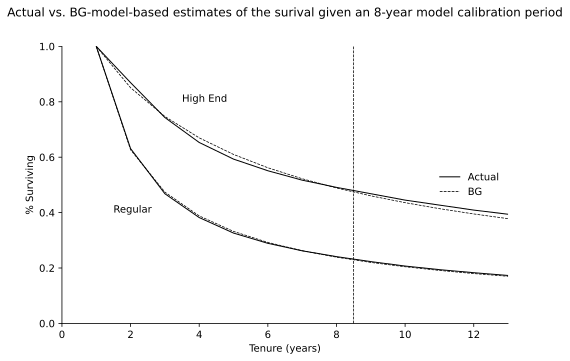

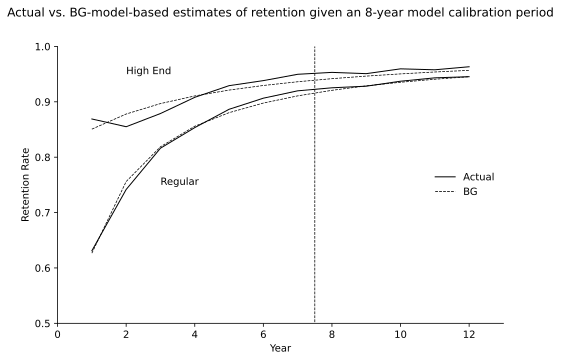

In [6]:
res_regular = sbg_param(year[:8], alive_regular[:8])
gamma, delta = res_regular.x
ll = res_regular.fun
est_survivor_function_regular = sbg_S(gamma, delta, year - 1)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]

display_markdown(f'''**Regular Customers:**

Parameters:
- $\\gamma$ = {gamma:0.4f}
- $\\delta$ = {delta:0.4f}

Log-Likelihood = {-ll:0.4f}

Summary Stats: $E(\\Theta)$ = {beta_mean(gamma, delta):0.3f}, $\\phi$ = {polarization_index(gamma, delta):0.3f}''', raw=True)

res_highend = sbg_param(year[:8], alive_highend[:8])
gamma, delta = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = sbg_S(gamma, delta, year - 1)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]

display_markdown(f'''**High-End Customers:**
                 
Parameters:
- $\\gamma$ = {gamma:0.4f}
- $\\delta$ = {delta:0.4f}

Log-Likelihood = {-ll:0.4f}

Summary Stats: $E(\\Theta)$ = {beta_mean(gamma, delta):0.3f}, $\\phi$ = {polarization_index(gamma, delta):0.3f}''', raw=True)

survival_plot(est_sf = est_survivor_function_regular, 
              est_sf_highend = est_survivor_function_highend,
              calib_p = 8,
              model= 'BG')

retention_plot(est_rr = est_retention_rate_regular,
               est_rr_highend = est_retention_rate_highend,
               calib_p = 8,
               model = 'BG')

**Regular Customers:**

Parameters:
- $\gamma$ = 0.7637
- $\delta$ = 1.2958

Log-Likelihood = -1401.5594

Summary Stats: $E(\Theta)$ = 0.371, $\phi$ = 0.327

**High-End Customers:**
                 
Parameters:
- $\gamma$ = 1.2809
- $\delta$ = 7.7897

Log-Likelihood = -1225.1349

Summary Stats: $E(\Theta)$ = 0.141, $\phi$ = 0.099

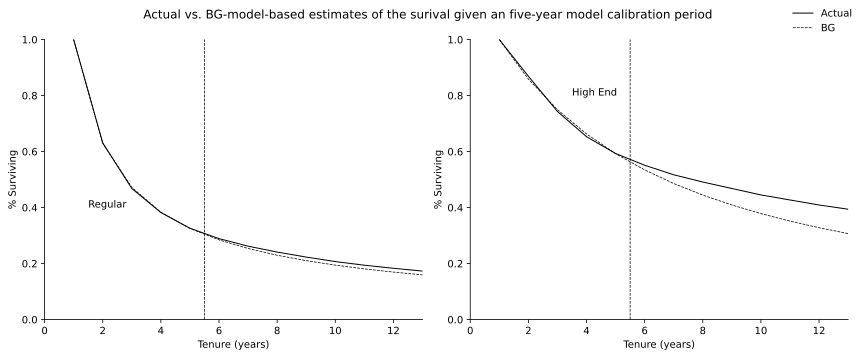

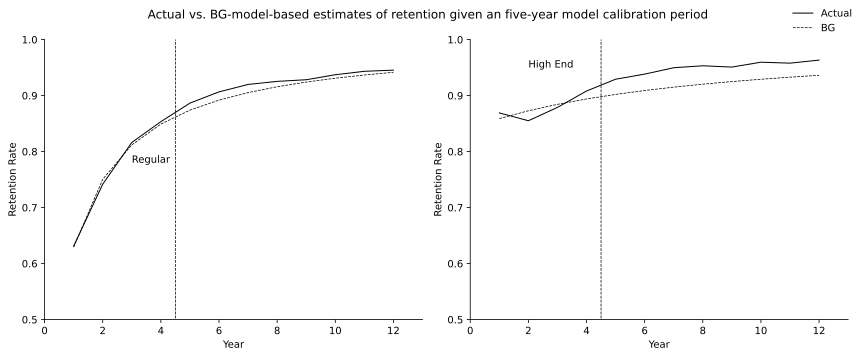

In [7]:
res_regular = sbg_param(year[:5], alive_regular[:5])
gamma, delta = res_regular.x
ll_bg_regular = res_regular.fun
est_survivor_function_regular = sbg_S(gamma, delta, year - 1)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]

display_markdown(f'''**Regular Customers:**

Parameters:
- $\\gamma$ = {gamma:0.4f}
- $\\delta$ = {delta:0.4f}

Log-Likelihood = {-ll_bg_regular:0.4f}

Summary Stats: $E(\\Theta)$ = {beta_mean(gamma, delta):0.3f}, $\\phi$ = {polarization_index(gamma, delta):0.3f}''', raw=True)

res_highend = sbg_param(year[:5], alive_highend[:5])
gamma, delta = res_highend.x
ll_bg_highend = res_highend.fun
est_survivor_function_highend = sbg_S(gamma, delta, year - 1)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]

display_markdown(f'''**High-End Customers:**
                 
Parameters:
- $\\gamma$ = {gamma:0.4f}
- $\\delta$ = {delta:0.4f}

Log-Likelihood = {-ll_bg_highend:0.4f}

Summary Stats: $E(\\Theta)$ = {beta_mean(gamma, delta):0.3f}, $\\phi$ = {polarization_index(gamma, delta):0.3f}''', raw=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
ax1, ax2 = axes
ax1.plot(year, survivor_function_regular, "k-", linewidth=1, label='Actual')
ax1.plot(year, est_survivor_function_regular, "k--", linewidth=0.75, label='BG')
ax1.text(x=1.5, y=0.4, s='Regular')
ax2.plot(year, survivor_function_highend, "k-", linewidth=1)
ax2.plot(year, est_survivor_function_highend, "k--", linewidth=0.75)
ax2.text(x=3.5, y=0.8, s='High End')
def plotting_elements(ax):
    ax.plot([5.5 for _ in np.arange(0,1.1,0.5)], [_ for _ in np.arange(0,1.1,0.5)], "k--", linewidth=0.75)
    ax.set_xlabel("Tenure (years)")
    ax.set_ylabel("% Surviving")
    ax.set_ylim(0,1)
    ax.set_xlim(0, 13)
plotting_elements(ax1)
plotting_elements(ax2)
fig.suptitle('Actual vs. BG-model-based estimates of the surival given an five-year model calibration period')
fig.tight_layout()
fig.legend(loc=1,frameon=False);

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
ax1, ax2 = axes
ax1.plot(year[1:]-1, retention_rate_regular, "k-", linewidth=1, label='Actual')
ax1.plot(year[1:]-1, est_retention_rate_regular, "k--", linewidth=0.75, label='BG')
ax1.text(x=3, y=0.78, s='Regular')
ax2.plot(year[1:]-1, retention_rate_highend, "k-", linewidth=1)
ax2.plot(year[1:]-1, est_retention_rate_highend, "k--", linewidth=0.75)
ax2.text(x=2, y=0.95, s='High End')
def plotting_elements(ax):
    ax.plot([4.5 for _ in np.arange(0,1.1,0.5)], [_ for _ in np.arange(0,1.1,0.5)], "k--", linewidth=0.75)
    ax.set_xlabel("Year")
    ax.set_ylabel("Retention Rate")
    ax.set_ylim(0.5,1)
    ax.set_xlim(0, 13)
plotting_elements(ax1)
plotting_elements(ax2)
fig.suptitle('Actual vs. BG-model-based estimates of retention given an five-year model calibration period')
fig.tight_layout()
fig.legend(loc=1,frameon=False);

Discrete Weibull (dW) Model

In [8]:
def dw_S(theta, c, t):
    return (1-theta)**(t**c)

def dw_param(year, alive):
    num_lost = alive[:-1] - alive[1:]
    
    def log_likelihood(x):
        theta, c = x[0], x[1]
        survivor_function = dw_S(theta, c, year-1)
        pmf = survivor_function[:-1] - survivor_function[1:]
        return -np.sum(num_lost * np.log(pmf)) - (alive[-1] * np.log(survivor_function[-1]))
    
    return minimize(log_likelihood, x0=[0.4,0.4], bounds=[(0.001, np.inf), (0.001, np.inf)])

**Regular Customers:**

Parameters:
- $\theta$ = 0.3739
- $c$ = 0.6359

Log-Likelihood = -1404.0082

**High-End Customers:**
                 
Parameters:
- $\theta$ = 0.1384
- $c$ = 0.9101

Log-Likelihood = -1226.5489

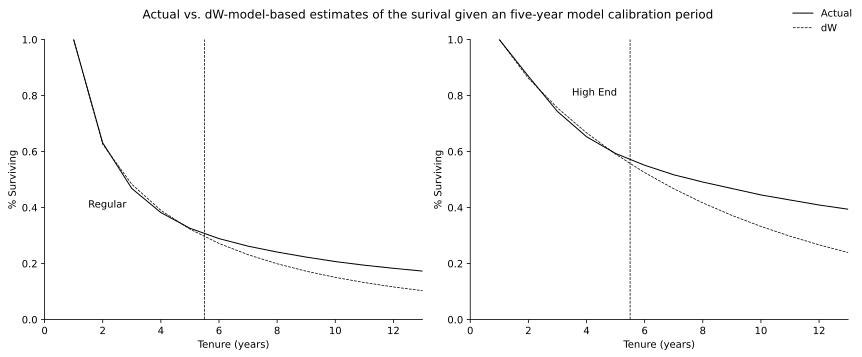

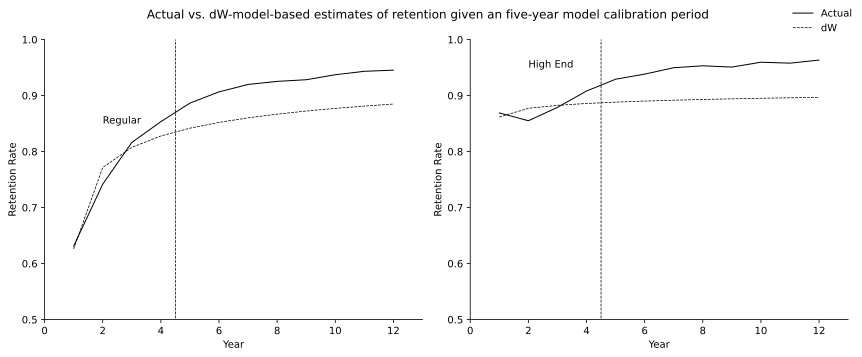

In [9]:
res_regular = dw_param(year[:5], alive_regular[:5])
theta, c = res_regular.x
ll = res_regular.fun
est_survivor_function_regular = dw_S(theta, c, year-1)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]

display_markdown(f'''**Regular Customers:**

Parameters:
- $\\theta$ = {theta:0.4f}
- $c$ = {c:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

res_highend = dw_param(year[:5], alive_highend[:5])
theta, c = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = dw_S(theta, c, year-1)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]

display_markdown(f'''**High-End Customers:**
                 
Parameters:
- $\\theta$ = {theta:0.4f}
- $c$ = {c:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
ax1, ax2 = axes
ax1.plot(year, survivor_function_regular, "k-", linewidth=1, label='Actual')
ax1.plot(year, est_survivor_function_regular, "k--", linewidth=0.75, label='dW')
ax1.text(x=1.5, y=0.4, s='Regular')
ax2.plot(year, survivor_function_highend, "k-", linewidth=1)
ax2.plot(year, est_survivor_function_highend, "k--", linewidth=0.75)
ax2.text(x=3.5, y=0.8, s='High End')
def plotting_elements(ax):
    ax.plot([5.5 for _ in np.arange(0,1.1,0.5)], [_ for _ in np.arange(0,1.1,0.5)], "k--", linewidth=0.75)
    ax.set_xlabel("Tenure (years)")
    ax.set_ylabel("% Surviving")
    ax.set_ylim(0,1)
    ax.set_xlim(0, 13)
plotting_elements(ax1)
plotting_elements(ax2)
fig.suptitle('Actual vs. dW-model-based estimates of the surival given an five-year model calibration period')
fig.tight_layout()
fig.legend(loc=1,frameon=False);

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
ax1, ax2 = axes
ax1.plot(year[1:]-1, retention_rate_regular, "k-", linewidth=1, label='Actual')
ax1.plot(year[1:]-1, est_retention_rate_regular, "k--", linewidth=0.75, label='dW')
ax1.text(x=2, y=0.85, s='Regular')
ax2.plot(year[1:]-1, retention_rate_highend, "k-", linewidth=1)
ax2.plot(year[1:]-1, est_retention_rate_highend, "k--", linewidth=0.75)
ax2.text(x=2, y=0.95, s='High End')
def plotting_elements(ax):
    ax.plot([4.5 for _ in np.arange(0,1.1,0.5)], [_ for _ in np.arange(0,1.1,0.5)], "k--", linewidth=0.75)
    ax.set_xlabel("Year")
    ax.set_ylabel("Retention Rate")
    ax.set_ylim(0.5,1)
    ax.set_xlim(0, 13)
plotting_elements(ax1)
plotting_elements(ax2)
fig.suptitle('Actual vs. dW-model-based estimates of retention given an five-year model calibration period')
fig.tight_layout()
fig.legend(loc=1,frameon=False);

Beta-discrete-Weibull (BdW) Model

In [10]:
def bdw_S(gamma, delta, c, t):
    return beta_fn(gamma, delta+t**c) / beta_fn(gamma, delta)

def bdw_param(year, alive):
    num_lost = alive[:-1] - alive[1:]
    
    def log_likelihood(x):
        gamma, delta, c = x[0], x[1],x[2]
        survivor_function = bdw_S(gamma, delta, c, year-1)
        pmf = survivor_function[:-1] - survivor_function[1:]
        return -np.sum(num_lost * np.log(pmf)) - (alive[-1] * np.log(survivor_function[-1]))
    
    return minimize(log_likelihood, x0=[0.1,0.1,0.1], bounds=[(0, np.inf), (0, np.inf), (0, np.inf)])

def retention_curve(c, gamma, delta, year):
    return beta_fn(gamma, delta + year**c)/beta_fn(gamma, delta + (year-1)**c)

**Regular Customers:**

Parameters:
- $\gamma$ = 0.5231
- $\delta$ = 0.8944
- $c$ = 1.1963

Log-Likelihood = -1401.3831

Summary Stats: $E(\Theta)$ = 0.369, $\phi$ = 0.414

Model Fit: LR = 0.35, p-Value = 0.553

**High End Customers:**

Parameters:
- $\gamma$ = 0.2593
- $\delta$ = 1.7225
- $c$ = 1.5844

Log-Likelihood = -1222.7493

Summary Stats: $E(\Theta)$ = 0.131, $\phi$ = 0.335

Model Fit: LR = 4.77, p-Value = 0.029

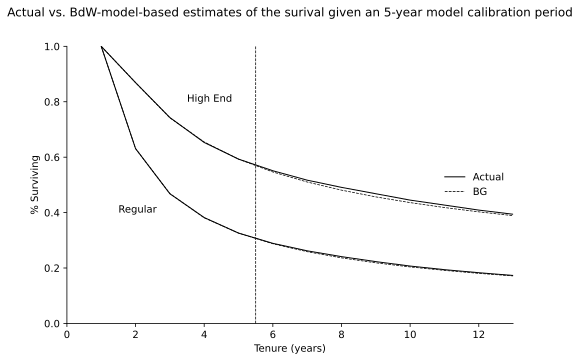

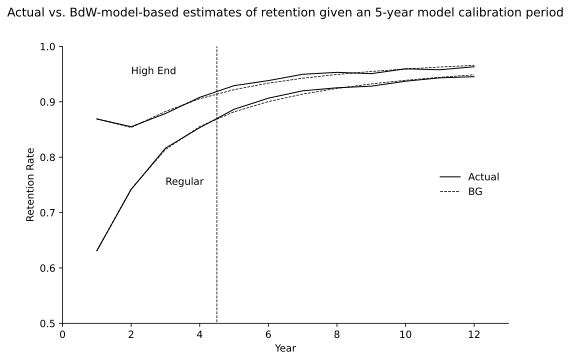

In [11]:
res_regular = bdw_param(year[:5], alive_regular[:5])
gamma, delta, c = res_regular.x
ll = res_regular.fun
est_survivor_function_regular = bdw_S(gamma, delta, c, year-1)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]
# Model Fit - BG vs. BdW 
lr = 2 * (ll_bg_regular - ll)
p_value = chi2.sf(lr, df=1)

display_markdown(f'''**Regular Customers:**

Parameters:
- $\\gamma$ = {gamma:0.4f}
- $\\delta$ = {delta:0.4f}
- $c$ = {c:0.4f}

Log-Likelihood = {-ll:0.4f}

Summary Stats: $E(\\Theta)$ = {beta_mean(gamma, delta):0.3f}, $\\phi$ = {polarization_index(gamma, delta):0.3f}

Model Fit: LR = {lr:.2f}, p-Value = {p_value:.3f}''', raw=True)

res_highend = bdw_param(year[:5], alive_highend[:5])
gamma, delta, c = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = bdw_S(gamma, delta, c, year-1)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]
# Model Fit - BG vs. BdW 
lr = 2 * (ll_bg_highend - ll)
p_value = chi2.sf(lr, df=1)

display_markdown(f'''**High End Customers:**

Parameters:
- $\\gamma$ = {gamma:0.4f}
- $\\delta$ = {delta:0.4f}
- $c$ = {c:0.4f}

Log-Likelihood = {-ll:0.4f}

Summary Stats: $E(\\Theta)$ = {beta_mean(gamma, delta):0.3f}, $\\phi$ = {polarization_index(gamma, delta):0.3f}

Model Fit: LR = {lr:.2f}, p-Value = {p_value:.3f}''', raw=True)

survival_plot(est_sf = est_survivor_function_regular, 
              est_sf_highend = est_survivor_function_highend,
              calib_p = 5,
              model= 'BdW')

retention_plot(est_rr = est_retention_rate_regular,
               est_rr_highend = est_retention_rate_highend,
               calib_p = 5,
               model = 'BdW')

The parameters of the beta distribution can be characterized in terms of the mean $E(Θ) = γ/(γ+δ)$ and polarization index $\phi = 1/(γ+δ+1)$. The logic behind the polarization index is as follows: as $γ, δ → 0$ (thus $\phi → 1$), the values of $θ$ are concentrated near $θ = 0$ and $θ = 1$ and we can think of the values of $θ$ as being very different, or “highly polarized.” As $γ, δ → ∞$ (thus $\phi → 0$), the beta distribution becomes a spike at its mean; there is no “polarization” in the values of $θ$.

Given the five-year calibration period parameter estimates for the High End dataset from the BG model estimates, $\hat\phi_{BG} = 0.099$; given the parameter estimates from BdW model estimation, $\hat\phi_{BdW} = 0.335$. We observe that there is greater heterogeneity in the presence of the positive duration dependence to capture the dominant pattern of increasing aggregate retention rates observed in the data.


Exploring the Shape of r(t)

In [12]:
case1 = beta(a=4.75, b=14.25)
case2 = beta(a=0.5, b=1.5)
case3 = beta(a=0.083, b=0.25)
x = np.arange(0,1.01,0.01)

While the associated distributions of $Θ$ have the same mean ($E(Θ) = 0.25$), they take on quite different shapes. In Case 1, the distribution of $Θ$ is relatively homogeneous ($\phi = 0.05$) with an interior mode. In Case 2, there is quite a bit of heterogeneity ($\phi = 0.33$) in the distribution of $Θ$, with the majority of
individuals having lowish values of $θ$. The heterogeneity in Case 3 ($\phi = 0.75$) is extreme; this U-shaped distribution indicates that some of the acquired customers have a high value of $θ$ (which maps to a low probability of renewal), while a larger number of customers have small values of $θ$.

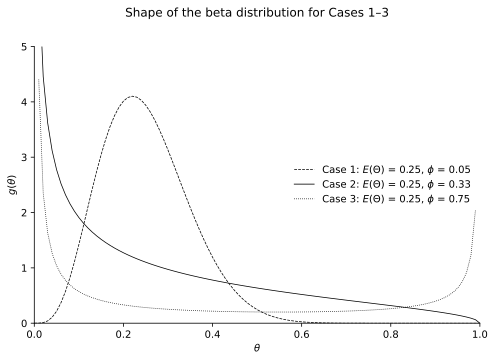

In [13]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(x, case1.pdf(x), "k--", linewidth=0.75, label=f'Case 1: $E(\\Theta)$ = {case1.mean():0.2f}, $\\phi$ = {polarization_index(4.75,14.25):0.2f}')
plt.plot(x, case2.pdf(x), "k-", linewidth=0.75, label=f'Case 2: $E(\\Theta)$ = {case2.mean():0.2f}, $\\phi$ = {polarization_index(0.5,1.5):0.2f}')
plt.plot(x, case3.pdf(x), "k:", linewidth=0.75, label=f'Case 3: $E(\\Theta)$ = {case3.mean():0.2f}, $\\phi$ = {polarization_index(0.083,0.25):0.2f}')
plt.xlabel("$\\theta$")
plt.ylabel("$g(\\theta)$")
plt.title('Shape of the beta distribution for Cases 1–3', pad=30)
plt.ylim(0,5)
plt.xlim(0, 1)
plt.legend(loc=7, frameon=False);

In [14]:
# Iiteratively increases γ until the polarization is smaller than a specified threshold
def target_beta_param(target_mean, target_polarization=1e-2):
    gamma = 1  # Start with a small gamma value
    while True:
        delta = gamma * (1 / target_mean - 1) # when mean is know, rerrange γ/(γ+δ) to isolate δ 
        polarization = 1 / (gamma + delta + 1)
        if polarization < target_polarization:
            break
        gamma += 1
    return gamma, delta, polarization
mean = 0.25
gamma, delta, polarization = target_beta_param(target_mean=mean)
print(f"Gamma: {gamma}, Delta: {delta}, Polarization: {polarization:0.2f}")

Gamma: 25, Delta: 75.0, Polarization: 0.01


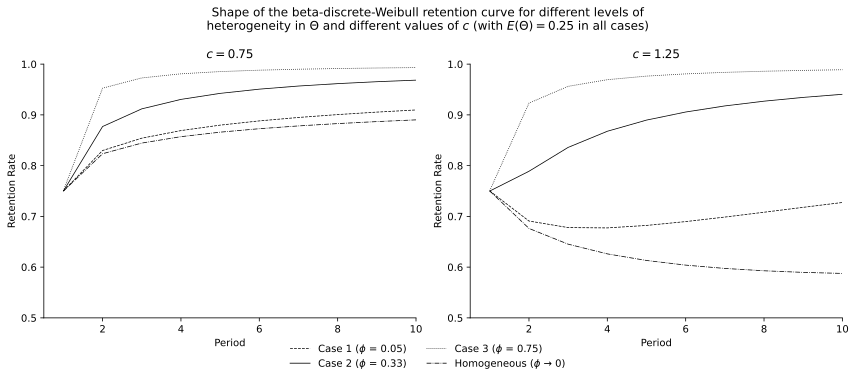

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
c_range  = [0.75, 1.25]
for i in range(2):
    ax = axes[i]
    ax.plot(year, retention_curve(c_range[i], 4.75, 14.25, year), "k--", linewidth=0.75, label=f'Case 1 ($\\phi$ = {polarization_index(4.75,14.25):0.2f})')
    ax.plot(year, retention_curve(c_range[i], 0.5, 1.5, year), "k-", linewidth=0.75, label=f'Case 2 ($\\phi$ = {polarization_index(0.5,1.5):0.2f})')
    ax.plot(year, retention_curve(c_range[i], 0.083, 0.25, year), "k:", linewidth=0.75, label=f'Case 3 ($\\phi$ = {polarization_index(0.083,0.25):0.2f})')
    ax.plot(year, retention_curve(c_range[i], 25, 75, year), "k-.", linewidth=0.75, label='Homogeneous ($\\phi$ → 0)')
    ax.set_xlabel("Period")
    ax.set_ylabel("Retention Rate")
    ax.set_ylim(0.5,1)
    ax.set_xlim(0.5, 10)
    ax.set_title(f'$c = {c_range[i]}$')   
fig.suptitle('Shape of the beta-discrete-Weibull retention curve for different levels of\nheterogeneity in $Θ$ and different values of $c$ (with $E(Θ) = 0.25$ in all cases)')
fig.legend(*axes[1].get_legend_handles_labels(),loc='lower center', frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.05)); 
fig.tight_layout()  

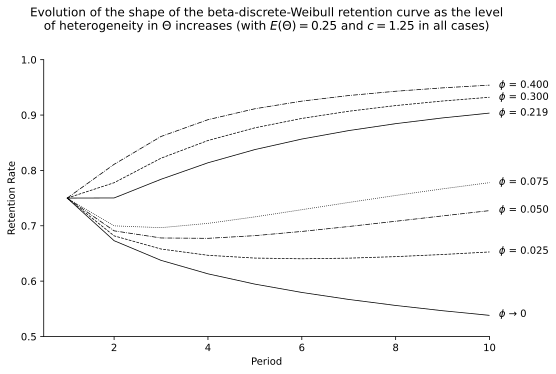

In [16]:
c_target  = 1.25
mean_target = 0.25
polarization_range = [0.001, 0.025, 0.05, 0.075, 0.219, 0.3, 0.4]
dashed_lines = ['k-', 'k--', 'k-.', 'k:','k-','k--', 'k-.']

plt.figure(figsize=(8,5), dpi=100)
for i, pol in enumerate(polarization_range):
    implied_gamma, implied_delta = beta_params(pol, mean_target)
    y = retention_curve(c_target, implied_gamma, implied_delta, year[:-3])
    plt.plot(year[:-3], y, dashed_lines[i], 
             linewidth=0.75, label=f'Case {i+1} ($\\phi$ = {pol})')
    plt.annotate(f'$\\phi$ = {pol:.3f}' if pol != 0.001 else '$\\phi$ → 0', 
                 xy=(year[-4], y[-1]),
                 xytext=(1.02*year[-4], 0.995*y[-1]))
plt.xlabel("Period")
plt.ylabel("Retention Rate")
plt.title('Evolution of the shape of the beta-discrete-Weibull retention curve as the level\n\
of heterogeneity in $\\Theta$ increases (with $E(\\Theta) = 0.25$ and $c = 1.25$ in all cases)', pad=30)
plt.ylim(0.5,1)
plt.xlim(0.5, 10);

“Beta of Second Kind” (B2) Distribution Model

In [17]:
def b2_S(r, alpha, s, x):
    return 1 - (1/(s * beta_fn(r,s))) * (alpha/(alpha + x))**r * \
           (x / (alpha + x))**s * hyp2f1(r+s, 1, s+1, x/(alpha + x))

def b2_param(year, alive):
    num_lost = alive[:-1] - alive[1:]
    
    def log_likelihood(x):
        r, alpha, s = x[0], x[1],x[2]
        survivor_function = b2_S(r, alpha, s, year-1)
        pmf = survivor_function[:-1] - survivor_function[1:]
        return -np.sum(num_lost * np.log(pmf)) - (alive[-1] * np.log(survivor_function[-1]))
    
    return minimize(log_likelihood, x0=[0.1,0.1,0.1], bounds=[(0, np.inf), (0, np.inf), (0, np.inf)])

**Regular Customers:**

Parameters:
- $r$ = 0.6529
- $\alpha$ = 0.4854
- $s$ = 1.6339

Log-Likelihood = -1401.3794

**High End Customers:**

Parameters:
- $r$ = 0.4835
- $\alpha$ = 0.5617
- $s$ = 2.7210

Log-Likelihood = -1222.7863

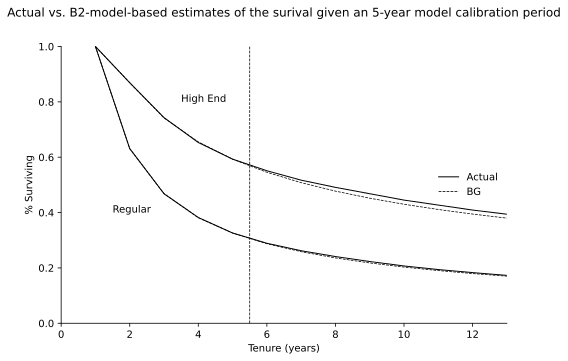

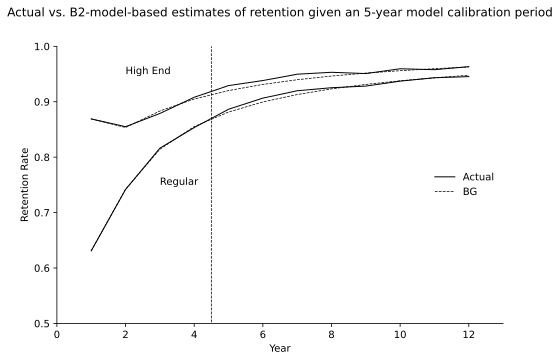

In [18]:
res_regular = b2_param(year[:5], alive_regular[:5])
r, alpha, s = res_regular.x
ll = res_regular.fun
est_survivor_function_regular = b2_S(r, alpha, s, year - 1)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]

display_markdown(f'''**Regular Customers:**

Parameters:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}
- $s$ = {s:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

res_highend = b2_param(year[:5], alive_highend[:5])
r, alpha, s = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = b2_S(r, alpha, s, year - 1)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}
- $s$ = {s:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

survival_plot(est_sf = est_survivor_function_regular, 
              est_sf_highend = est_survivor_function_highend,
              calib_p = 5,
              model= 'B2')

retention_plot(est_rr = est_retention_rate_regular,
               est_rr_highend = est_retention_rate_highend,
               calib_p = 5,
               model = 'B2')

2-Segment Discrete Weibull (dW) Model

In [19]:
def ll_function(observed_churn, observed_alive_t, pmf, survival_func_t):
    '''
    observed_churn: number of customers chruned each period
    observed_alive_t: number of customers alive at the end of the calibration period
    pmf: probability mass function
    survival_func_t: 
    '''
    return np.sum(observed_churn * np.log(pmf)) - (observed_alive_t * np.log(survival_func_t))

def seg2_dw_S(theta1, theta2, c1, c2, pi, t):
    return pi*(1-theta1)**(t**c1) + (1-pi)*(1-theta2)**(t**c2)

# 2-Segment Discrete Weibull (dW) Model - Heterogenous θ and Heterogenous c
def seg2_dW_param(year, alive):
    num_lost = alive[:-1] - alive[1:]
    
    def log_likelihood(x):
        theta1, theta2, c1, c2, pi = x
        survivor_function = seg2_dw_S(theta1, theta2, c1, c2, pi, year - 1)
        pmf = survivor_function[:-1] - survivor_function[1:]
        return -np.sum(num_lost * np.log(pmf)) - (alive[-1] * np.log(survivor_function[-1]))
    
    guess = [0.05,0.1,0.5,1,0.5]
    bounds = [(1e-4, 1), (1e-4, 1), (1e-4, np.inf), (1e-4, np.inf), (1e-4, 1)]
    return minimize(log_likelihood, x0=guess, bounds=bounds)

# 2-Segment Discrete Weibull (dW) Model - Heterogenous θ and Homogenous c
def seg2_dW_homc_param(year, alive):
    num_lost = alive[:-1] - alive[1:]
    
    def log_likelihood(x):
        theta1, theta2, c, pi = x
        t = year - 1
        survivor_function = pi*(1-theta1)**(t**c) + (1-pi)*(1-theta2)**(t**c)
        pmf = survivor_function[:-1] - survivor_function[1:]
        return -np.sum(num_lost * np.log(pmf)) - (alive[-1] * np.log(survivor_function[-1]))
    
    guess = [0.05,0.1,0.5,0.5]
    bounds = [(1e-4, 1), (1e-4, 1), (1e-4, np.inf), (1e-4, 1)]
    return minimize(log_likelihood, x0=guess, bounds=bounds)

# 2-Segment Discrete Weibull (dW) Model - Homogenous θ and Homogenous c
def seg2_dW_homt_param(year, alive):
    num_lost = alive[:-1] - alive[1:]
    
    def log_likelihood(x):
        theta, c1, c2, pi = x
        t = year - 1
        survivor_function = pi*(1-theta)**(t**c1) + (1-pi)*(1-theta)**(t**c2)
        pmf = survivor_function[:-1] - survivor_function[1:]
        return -np.sum(num_lost * np.log(pmf)) - (alive[-1] * np.log(survivor_function[-1]))
    
    guess = [0.05,0.5, 1,0.5]
    bounds = [(1e-4, 1), (1e-4, np.inf), (1e-4, np.inf), (1e-4, 1)]
    return minimize(log_likelihood, x0=guess, bounds=bounds)

The five model parameters are not identified if we use the five-year model calibration period (as we only observe four renewal opportunities). We will therefore use the whole dataset, which contains 12 renewal opportunities, in our investigations of heterogeneity in $c$.

In [70]:
# https://en.wikipedia.org/wiki/Akaike_information_criterion
def aic(k, log_likelihood):
    '''
    k: number of parameters in the model
    log_likelihood: minimized, negative log value of the likelihood function
    '''
    return (2*k) + (2*log_likelihood)

# https://en.wikipedia.org/wiki/Bayesian_information_criterion
def bic(k, n, log_likelihood):
    '''
    k: number of parameters in the model
    n: number of data points or number of observations, i.e. the x in the  likelihood function L = p(x | θ, M)
       where M is the model, θ  are the parameters values that maximize the likelihood function and x is the observed data
       x in our case is the total number of customers in in the cohort
    log_likelihood: minimized, negative log value of the likelihood function
    '''    
    return (k*np.log(n)) + (2*log_likelihood)

def evidence_ratio(aic_i, aci_min):
    '''
    Evidence ratio: E_{i} = exp((AIC_{i} - AIC_{min})/2)
    '''
    return np.exp((aic_i - aci_min)/2)

**High End Customers:**

Parameters:
- $\theta_{1}$ = 0.2014
- $\theta_{2}$ = 0.5467
- $c_{1}$ = 0.6348
- $c_{2}$ = 0.9308
- $\pi$ = 0.5131

Log-Likelihood = -1930.8772

Model Fit:
- AIC = 3871.8
- BIC = 3896.3

**High End Customers:**

Parameters:
- $\theta_{1}$ = 0.0679
- $\theta_{2}$ = 0.2888
- $c_{1}$ = 0.8549
- $c_{2}$ = 1.3834
- $\pi$ = 0.7095

Log-Likelihood = -2004.3176

Model Fit:
- AIC = 4018.6
- BIC = 4043.2
- Evidence ratio = 4.56137582696509

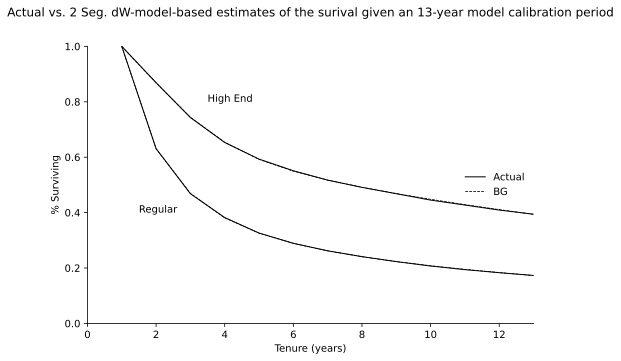

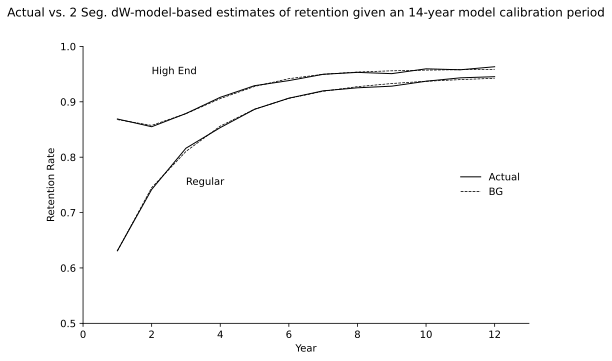

In [69]:
res_regular = seg2_dW_param(year, alive_regular)
theta1, theta2, c1, c2, pi = res_regular.x
ll = res_regular.fun
est_survivor_function_regular = seg2_dw_S(theta1, theta2, c1, c2, pi, year - 1)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $\\theta_{{1}}$ = {theta1:0.4f}
- $\\theta_{{2}}$ = {theta2:0.4f}
- $c_{{1}}$ = {c1:0.4f}
- $c_{{2}}$ = {c2:0.4f}
- $\\pi$ = {pi:0.4f}

Log-Likelihood = {-ll:0.4f}

Model Fit:
- AIC = {aic(5,ll):.1f}
- BIC = {bic(5, 1000, ll):.1f}''', raw=True)

res_highend = seg2_dW_param(year, alive_highend)
theta1, theta2, c1, c2, pi = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = seg2_dw_S(theta1, theta2, c1, c2, pi, year - 1)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $\\theta_{{1}}$ = {theta1:0.4f}
- $\\theta_{{2}}$ = {theta2:0.4f}
- $c_{{1}}$ = {c1:0.4f}
- $c_{{2}}$ = {c2:0.4f}
- $\\pi$ = {pi:0.4f}

Log-Likelihood = {-ll:0.4f}

Model Fit:
- AIC = {aic(5,ll):.1f}
- BIC = {bic(5, 1000, ll):.1f}
- Evidence Ratio = {np.exp((aic(5,ll)-4015.6)/2)}''', raw=True)

survival_plot(est_sf = est_survivor_function_regular, 
              est_sf_highend = est_survivor_function_highend,
              calib_p = 13,
              model= '2 Seg. dW')

retention_plot(est_rr = est_retention_rate_regular,
               est_rr_highend = est_retention_rate_highend,
               calib_p = 14,
               model = '2 Seg. dW')

2-Segment Discrete Weibull (dW) Model - Heterogenous $\theta$ and Homogenous $c$

**High End Customers:**

Parameters:
- $\theta_{1}$ = 0.0873
- $\theta_{2}$ = 0.5431
- $c$ = 0.8700
- $\pi$ = 0.3806

Log-Likelihood = -1930.9088

Model Fit:
- AIC = 3869.8
- BIC = 3889.4

**High End Customers:**

Parameters:
- $\theta_{1}$ = 0.0195
- $\theta_{2}$ = 0.3019
- $c$ = 1.2323
- $\pi$ = 0.5995

Log-Likelihood = -2004.4818

Model Fit:
- AIC = 4017.0
- BIC = 4036.6

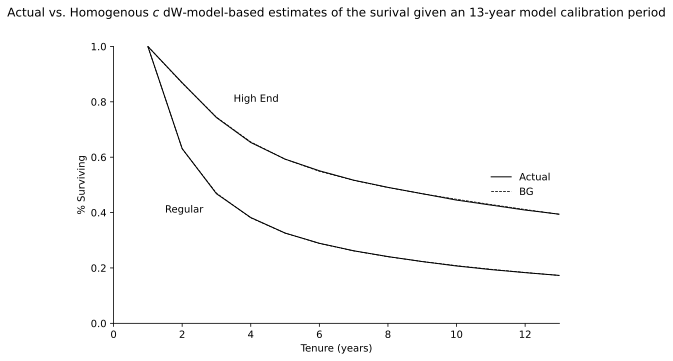

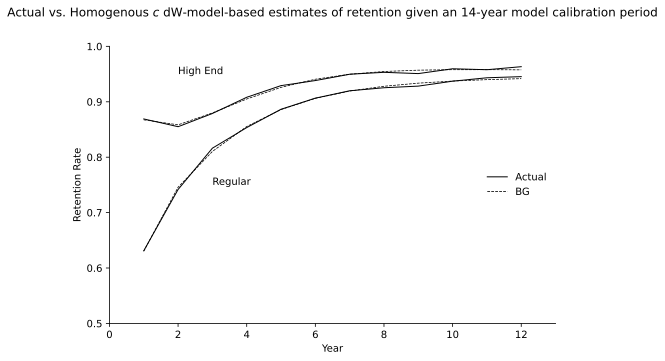

In [65]:
res_regular = seg2_dW_homc_param(year, alive_regular)
theta1, theta2, c, pi = res_regular.x
ll = res_regular.fun
t = year - 1
est_survivor_function_regular = pi*(1-theta1)**(t**c) + (1-pi)*(1-theta2)**(t**c)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $\\theta_{{1}}$ = {theta1:0.4f}
- $\\theta_{{2}}$ = {theta2:0.4f}
- $c$ = {c:0.4f}
- $\\pi$ = {pi:0.4f}

Log-Likelihood = {-ll:0.4f}

Model Fit:
- AIC = {aic(4,ll):.1f}
- BIC = {bic(4, 1000, ll):.1f}''', raw=True)

res_highend = seg2_dW_homc_param(year, alive_highend)
theta1, theta2, c, pi = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = pi*(1-theta1)**(t**c) + (1-pi)*(1-theta2)**(t**c)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $\\theta_{{1}}$ = {theta1:0.4f}
- $\\theta_{{2}}$ = {theta2:0.4f}
- $c$ = {c:0.4f}
- $\\pi$ = {pi:0.4f}

Log-Likelihood = {-ll:0.4f}

Model Fit:
- AIC = {aic(4,ll):.1f}
- BIC = {bic(4, 1000, ll):.1f}''', raw=True)

survival_plot(est_sf = est_survivor_function_regular, 
              est_sf_highend = est_survivor_function_highend,
              calib_p = 13,
              model= 'Homogenous $c$ dW')

retention_plot(est_rr = est_retention_rate_regular,
               est_rr_highend = est_retention_rate_highend,
               calib_p = 14,
               model = 'Homogenous $c$ dW')

2-Segment Discrete Weibull (dW) Model - Heterogenous $c$ and Homogenous $\theta$

**High End Customers:**

Parameters:
- $\theta$ = 0.3703
- $c_{1}$ = 0.4728
- $c_{2}$ = 1.4240
- $\pi$ = 0.7709

Log-Likelihood = -1931.1846

Model Fit:
- AIC = 3870.4
- BIC = 3890.0

**High End Customers:**

Parameters:
- $\theta$ = 0.1349
- $c_{1}$ = 0.6675
- $c_{2}$ = 2.2297
- $\pi$ = 0.8400

Log-Likelihood = -2005.3021

Model Fit:
- AIC = 4018.6
- BIC = 4038.2

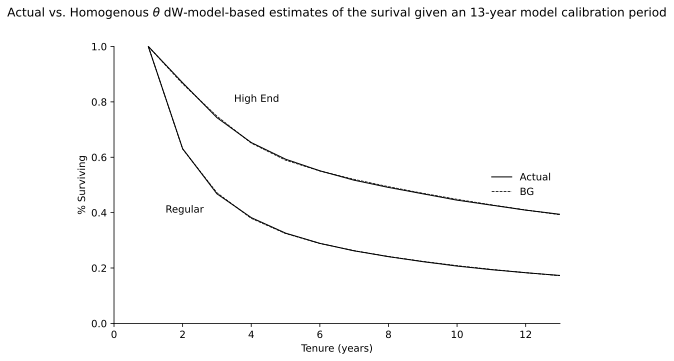

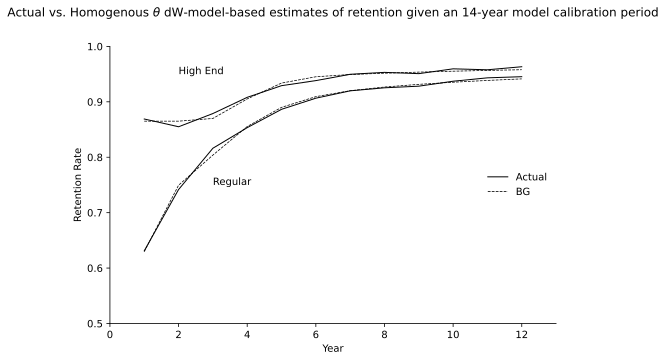

In [66]:
res_regular = seg2_dW_homt_param(year, alive_regular)
theta, c1, c2, pi = res_regular.x
ll = res_regular.fun
t = year - 1
est_survivor_function_regular = pi*(1-theta)**(t**c1) + (1-pi)*(1-theta)**(t**c2)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $\\theta$ = {theta:0.4f}
- $c_{{1}}$ = {c1:0.4f}
- $c_{{2}}$ = {c2:0.4f}
- $\\pi$ = {pi:0.4f}

Log-Likelihood = {-ll:0.4f}

Model Fit:
- AIC = {aic(4,ll):.1f}
- BIC = {bic(4, 1000, ll):.1f}''', raw=True)

res_highend = seg2_dW_homt_param(year, alive_highend)
theta, c1, c2, pi = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = pi*(1-theta)**(t**c1) + (1-pi)*(1-theta)**(t**c2)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $\\theta$ = {theta:0.4f}
- $c_{{1}}$ = {c1:0.4f}
- $c_{{2}}$ = {c2:0.4f}
- $\\pi$ = {pi:0.4f}

Log-Likelihood = {-ll:0.4f}

Model Fit:
- AIC = {aic(4,ll):.1f}
- BIC = {bic(4, 1000, ll):.1f}''', raw=True)

survival_plot(est_sf = est_survivor_function_regular, 
              est_sf_highend = est_survivor_function_highend,
              calib_p = 13,
              model= 'Homogenous $\\theta$ dW')

retention_plot(est_rr = est_retention_rate_regular,
               est_rr_highend = est_retention_rate_highend,
               calib_p = 14,
               model = 'Homogenous $\\theta$ dW')

Discrete Weibull (dW) Model - Homogenous $\theta$ and $c$

**High End Customers:**

Parameters:
- $\theta$ = 0.3879
- $c$ = 0.5302

Log-Likelihood = -1945.3479

Model Fit:
- AIC = 3894.7
- BIC = 3904.5

**High End Customers:**

Parameters:
- $\theta$ = 0.1598
- $c$ = 0.6875

Log-Likelihood = -2027.6838

Model Fit:
- AIC = 4059.4
- BIC = 4069.2

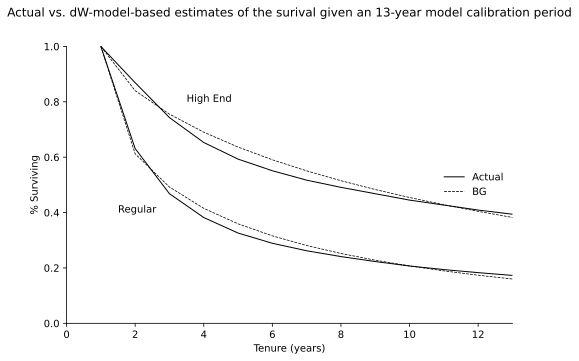

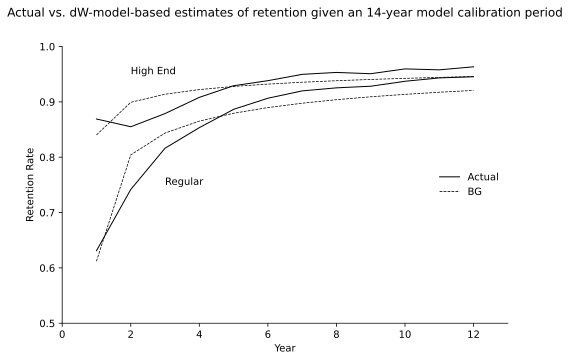

In [67]:
res_regular = dw_param(year, alive_regular)
theta, c = res_regular.x
ll = res_regular.fun
est_survivor_function_regular = (1-theta)**((year - 1)**c)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $\\theta$ = {theta:0.4f}
- $c$ = {c:0.4f}

Log-Likelihood = {-ll:0.4f}

Model Fit:
- AIC = {aic(2,ll):.1f}
- BIC = {bic(2, 1000, ll):.1f}''', raw=True)

res_highend = dw_param(year, alive_highend)
theta, c = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = (1-theta)**((year - 1)**c)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]

display_markdown(f'''**High End Customers:**

Parameters:
- $\\theta$ = {theta:0.4f}
- $c$ = {c:0.4f}

Log-Likelihood = {-ll:0.4f}

Model Fit:
- AIC = {aic(2,ll):.1f}
- BIC = {bic(2, 1000, ll):.1f}''', raw=True)

survival_plot(est_sf = est_survivor_function_regular, 
              est_sf_highend = est_survivor_function_highend,
              calib_p = 13,
              model= 'dW')

retention_plot(est_rr = est_retention_rate_regular,
               est_rr_highend = est_retention_rate_highend,
               calib_p = 14,
               model = 'dW')

**Regular Customers:**

Parameters:
- $\gamma$ = 0.5083
- $\delta$ = 0.8688
- $c$ = 1.2094

Log-Likelihood = -1930.9297

Summary Stats: $E(\Theta)$ = 0.369, $\phi$ = 0.421

Model Fit: 
- LR = -1058.74
- p-Value = 1.000
- AIC = 3867.9
- BIC = 3882.6

**High End Customers:**

Parameters:
- $\gamma$ = 0.2496
- $\delta$ = 1.6542
- $c$ = 1.5968

Log-Likelihood = -2004.8169

Summary Stats: $E(\Theta)$ = 0.131, $\phi$ = 0.344

Model Fit: 
- LR = -1559.36
- p-Value = 1.000
- AIC = 4015.6
- BIC = 4030.4

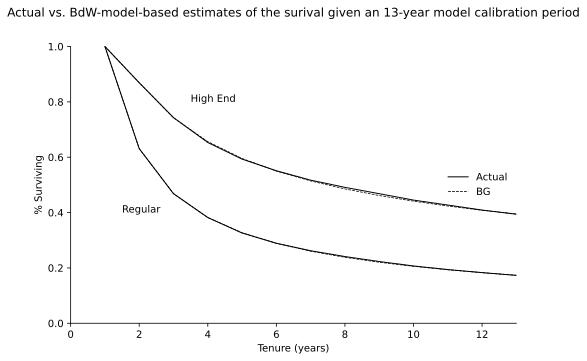

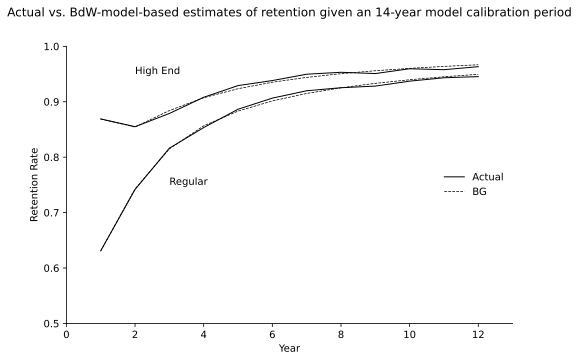

In [68]:
res_regular = bdw_param(year, alive_regular)
gamma, delta, c = res_regular.x
ll = res_regular.fun
est_survivor_function_regular = bdw_S(gamma, delta, c, year-1)
est_retention_rate_regular = est_survivor_function_regular[1:] / est_survivor_function_regular[:-1]
lr = 2 * (ll_bg_regular - ll)
p_value = chi2.sf(lr, df=1)

display_markdown(f'''**Regular Customers:**

Parameters:
- $\\gamma$ = {gamma:0.4f}
- $\\delta$ = {delta:0.4f}
- $c$ = {c:0.4f}

Log-Likelihood = {-ll:0.4f}

Summary Stats: $E(\\Theta)$ = {beta_mean(gamma, delta):0.3f}, $\\phi$ = {polarization_index(gamma, delta):0.3f}

Model Fit: 
- LR = {lr:.2f}
- p-Value = {p_value:.3f}
- AIC = {aic(3,ll):.1f}
- BIC = {bic(3, 1000, ll):.1f}''', raw=True)

res_highend = bdw_param(year, alive_highend)
gamma, delta, c = res_highend.x
ll = res_highend.fun
est_survivor_function_highend = bdw_S(gamma, delta, c, year-1)
est_retention_rate_highend = est_survivor_function_highend[1:] / est_survivor_function_highend[:-1]
lr = 2 * (ll_bg_highend - ll)
p_value = chi2.sf(lr, df=1)

display_markdown(f'''**High End Customers:**

Parameters:
- $\\gamma$ = {gamma:0.4f}
- $\\delta$ = {delta:0.4f}
- $c$ = {c:0.4f}

Log-Likelihood = {-ll:0.4f}

Summary Stats: $E(\\Theta)$ = {beta_mean(gamma, delta):0.3f}, $\\phi$ = {polarization_index(gamma, delta):0.3f}

Model Fit: 
- LR = {lr:.2f}
- p-Value = {p_value:.3f}
- AIC = {aic(3,ll):.1f}
- BIC = {bic(3, 1000, ll):.1f}''', raw=True)

survival_plot(est_sf = est_survivor_function_regular, 
              est_sf_highend = est_survivor_function_highend,
              calib_p = 13,
              model= 'BdW')

retention_plot(est_rr = est_retention_rate_regular,
               est_rr_highend = est_retention_rate_highend,
               calib_p = 14,
               model = 'BdW')

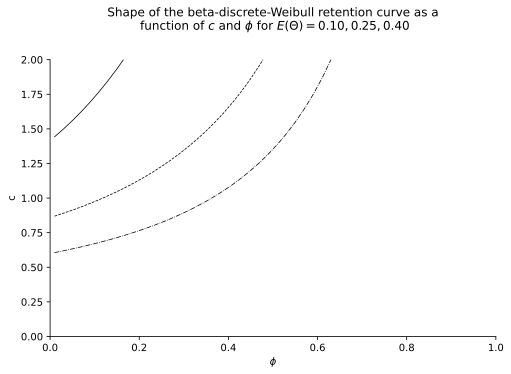

In [27]:
def c_est(gamma, delta, year=year[:5], alive=alive_regular[:5]):
    num_lost = alive[:-1] - alive[1:]
    
    def log_likelihood(x):
        c = x[0]
        survivor_function = beta_fn(gamma, delta+(year-1)**c) / beta_fn(gamma, delta)
        pmf = survivor_function[:-1] - survivor_function[1:]
        return -np.sum(num_lost * np.log(pmf)) - (alive[-1] * np.log(survivor_function[-1]))
    res = minimize(log_likelihood, x0=[0.1], bounds=[(0.01, np.inf)])
    return res.x

polarization_range = np.arange(0.01, 1, 0.02)
mean_range = [0.1, 0.25, 0.4]

plt.figure(figsize=(8,5), dpi=100)
for i, mu in enumerate(mean_range):
    implied_gamma, implied_delta = beta_params(polarization_range, mu)
    y = np.vectorize(c_est)(implied_gamma, implied_delta)
    plt.plot(polarization_range, y, dashed_lines[i], 
             linewidth=0.75, label=f'Case {i+1} ($\\phi$ = {pol})')
plt.xlabel("$\\phi$")
plt.ylabel("c")
plt.title('Shape of the beta-discrete-Weibull retention curve as a\n function of $c$ and $\\phi$ for $E(\\Theta) = {0.10, 0.25, 0.40}$', pad=30)
plt.ylim(0,2)
plt.xlim(0, 1);